<a href="https://colab.research.google.com/github/vivekbiju/XAI/blob/main/DenseNet201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow
!pip install opencv-python
!pip install seaborn
!pip install matplotlib
!pip install opencv-contrib-python
!pip install kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 119.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 108.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 MB 40.8 MB/s eta 0:00:00


In [6]:
#important library:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
import kagglehub
import warnings
import os
warnings.filterwarnings('ignore')
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, models

In [7]:
# Download dataset
path = kagglehub.dataset_download("bhaveshmittal/melanoma-cancer-dataset")
print("Path to dataset files:", path)

# Define train_path and test_path based on downloaded folder structure
train_path = os.path.join(path, "train")
test_path = os.path.join(path, "test")

# Count images
ben = len(os.listdir(os.path.join(train_path, "Benign")) + os.listdir(os.path.join(test_path, "Benign")))
mal = len(os.listdir(os.path.join(train_path, "Malignant")) + os.listdir(os.path.join(test_path, "Malignant")))

print(f"Number of images benign: {ben}")
print(f"Number of images malignant: {mal}")

Path to dataset files: /root/.cache/kagglehub/datasets/bhaveshmittal/melanoma-cancer-dataset/versions/1
Number of images benign: 7289
Number of images malignant: 6590


In [8]:
# Define constants
image_size = (224, 224)  # Rescale images to 224x224 pixels
batch_size = 32

# Get the list of subdirectories in the original training directory
subdirectories = os.listdir(train_path)

# Split the subdirectories into training and validation sets
train_subdirs, validation_subdirs = train_test_split(subdirectories, test_size=0.3, random_state=42)

# Create directories for training and validation data
train_data_dir = 'path/to/train_data'
os.makedirs(train_data_dir, exist_ok=True)

validation_data_dir = 'path/to/validation_data'
os.makedirs(validation_data_dir, exist_ok=True)

# Move images to the corresponding directories
for subdir in subdirectories:
    filenames = os.listdir(os.path.join(train_path, subdir))
    train_filenames, validation_filenames = train_test_split(filenames, test_size=0.3, random_state=42)

    for filename in train_filenames:
        src = os.path.join(train_path, subdir, filename)
        dst = os.path.join(train_data_dir, subdir, filename)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

    for filename in validation_filenames:
        src = os.path.join(train_path, subdir, filename)
        dst = os.path.join(validation_data_dir, subdir, filename)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

# Define data generators with augmentation for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 8315 images belonging to 2 classes.
Found 3564 images belonging to 2 classes.


In [9]:
# Evaluate the model
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 2000 images belonging to 2 classes.


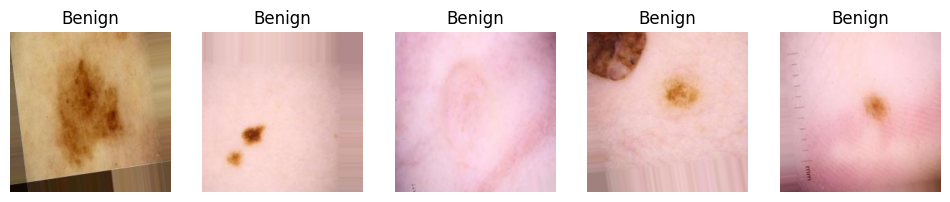

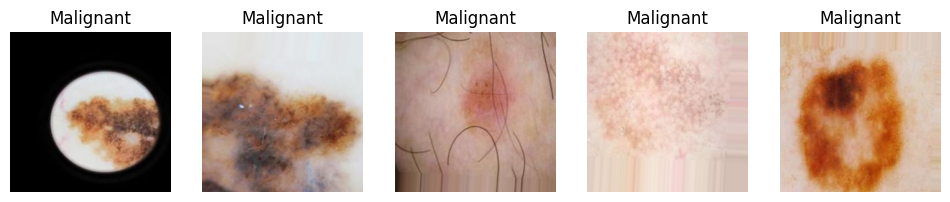

In [29]:
# Define the number of images to plot from each class
num_images_per_class = 5

# Get class indices
class_indices = test_generator.class_indices

# Inverse mapping of class indices to class labels
class_labels = {v: k for k, v in class_indices.items()}

# Plot images from each class
for class_index, class_label in class_labels.items():
    # Find the first num_images_per_class images belonging to the current class
    class_images = [image for image, label in zip(train_generator[0][0], train_generator[0][1]) if label[class_index] == 1][:num_images_per_class]

    # Ploting
    plt.figure(figsize=(12, 10))
    for i, image in enumerate(class_images):
        plt.subplot(1, num_images_per_class, i + 1)
        plt.imshow(image)
        plt.title(class_label)
        plt.axis('off')
    plt.show()


In [11]:
# Define the input shape
input_shape = (224, 224, 3)

base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='max')
x = base_model.output
BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)  # L2 regularization
x = layers.Dropout(0.5)(x)
output = layers.Dense(2, activation='softmax', kernel_regularizer=l2(0.001))(x)  # L2 regularization
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.0001)

model = models.Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [12]:
import time
start_time = time.time()
# Train the model and store the training history
history1 = model.fit(train_generator, epochs=15, validation_data=validation_generator)
end_time = time.time()
total_time = end_time - start_time
hours, rem = divmod(total_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"\nTotal training time: {int(hours)}h {int(minutes)}m {int(seconds)}s")


Epoch 1/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 610s 2s/step - accuracy: 0.7659 - loss: 1.3224 - val_accuracy: 0.8611 - val_loss: 0.5292
Epoch 2/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 551s 2s/step - accuracy: 0.8508 - loss: 0.5131 - val_accuracy: 0.8861 - val_loss: 0.4146
Epoch 3/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 551s 2s/step - accuracy: 0.8677 - loss: 0.4705 - val_accuracy: 0.8889 - val_loss: 0.3881
Epoch 4/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 550s 2s/step - accuracy: 0.8816 - loss: 0.3968 - val_accuracy: 0.8900 - val_loss: 0.3796
Epoch 5/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 550s 2s/step - accuracy: 0.8891 - loss: 0.3880 - val_accuracy: 0.8967 - val_loss: 0.3682
Epoch 6/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 551s 2s/step - accuracy: 0.9093 - loss: 0.3502 - val_accuracy: 0.8976 - val_loss: 0.3648
Epoch 7/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 550s 2s/step - accuracy: 0.9088 - loss: 0.3266 - val_accuracy: 0.9026 - val_loss: 0.3555
Epoch 8/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 551s 2s/step - accuracy: 0.9166 - loss: 0.3161 - val_accu

In [13]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

# Print the test accuracy
print("Test Accuracy:", test_accuracy)

# Evaluate the model on the train set
train_loss, train_accuracy = model.evaluate(train_generator)

# Print the test accuracy
print("Train Accuracy:", train_accuracy)

63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 432ms/step - accuracy: 0.9376 - loss: 0.2680
Test Accuracy: 0.9279999732971191
260/260 ━━━━━━━━━━━━━━━━━━━━ 116s 444ms/step - accuracy: 0.9743 - loss: 0.1753
Train Accuracy: 0.9737823009490967


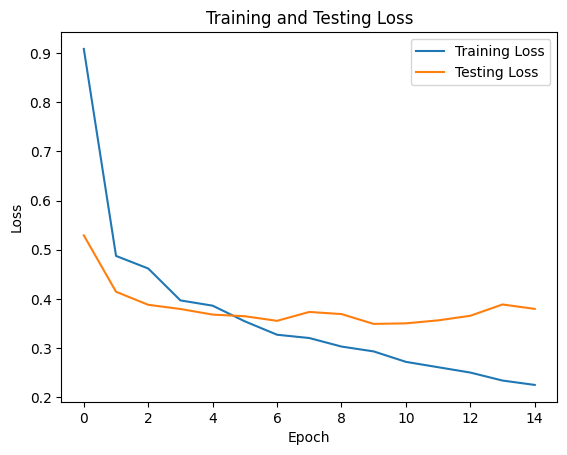

In [15]:
#plot the loss in each epoch
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

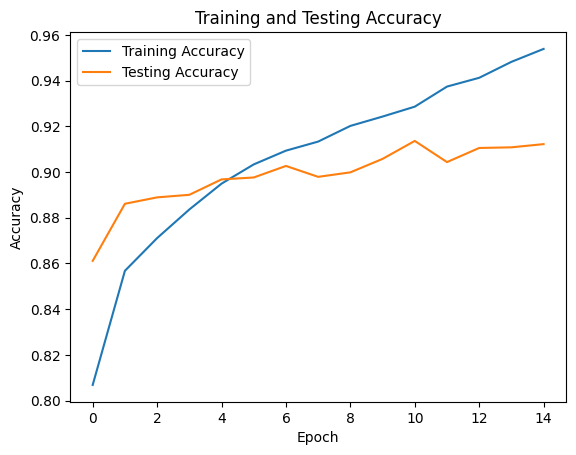

In [16]:
#plot the accuracy in each epoch
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()

In [17]:
#confusion matrix
predictions = model.predict(test_generator)

predicted_labels = np.argmax(predictions, axis=1)

true_labels = test_generator.classes

conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)
print('-------------------------------------------------------------------------')

class_report = classification_report(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 477ms/step
Confusion Matrix:
[[935  65]
 [ 79 921]]
-------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1000
           1       0.93      0.92      0.93      1000

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



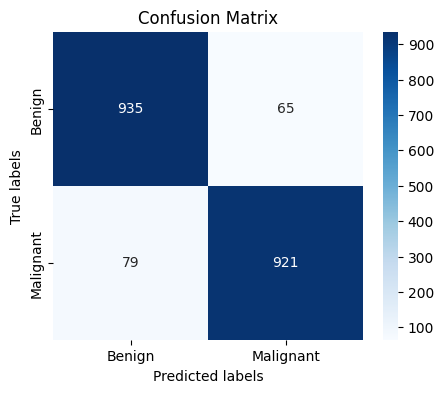

In [22]:
# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()